In [129]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sb
from matplotlib import rc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.pipeline import Pipeline
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, mean_squared_error
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import time
from collections import defaultdict

from sklearn import model_selection
from sklearn.feature_selection import SelectFromModel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score

from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from keras.activations import relu, tanh
from keras.optimizers import Adam

#from sknn.mlp import Regressor

from shrink_functions import X_y, time_split, ss
from model_functions import model_clusters, plot_rmse, clust_grid, forc_model_test
from std_scale import StdScale

In [45]:
%matplotlib inline
pd.set_option('max_columns',500)
font = {'size': 20}
rc('font', **font)
plt.style.use('seaborn-dark-palette')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [15]:
df = pd.read_pickle('../data/SRP/clean_data_public_no_crime_lag2_by_store_300k.pkl')
df_agg = df.groupby(['address1', 'visit_date']).mean().sort_index().reset_index()

cust_table_clust = pd.read_pickle('../data/SRP/cust_table_out.pkl')
df_agg = df_agg.join(cust_table_clust[['avg_UPC_per_visit', 'days_between_visits', 'cluster']], on='address1', how='left')

In [142]:
len(cust_table_clust) * 0.222 * 30.5

79884.258

In [18]:
id_cols = ['customer_id_2139', 'customer_id_1635139', 'customer_id_1903139',
       'customer_id_2331150', 'customer_id_2741156', 'customer_id_2773156',
       'customer_id_2782156', 'customer_id_2956160', 'customer_id_2977160',
       'customer_id_3083182', 'customer_id_3088198', 'customer_id_3088201',
       'customer_id_3089336', 'customer_id_3093327', 'customer_id_3093329',
       'customer_id_3097348']

for col in id_cols:
    df_agg[col] = df_agg[col].astype(np.uint8)

## Split into features and targets

In [71]:
non_feature_cols = ['shrink_value', 'shrink_to_sales_value_pct', 'shrink_value_out', 'shrink_to_sales_value_pct_out', 'shrink_value_ex_del', 
                    'shrink_to_sales_value_pct_ex_del', 'qty_inv_out', 'qty_shrink', 'qty_shrink_ex_del', 'qty_shrink_out', 'qty_end_inventory', 
                    'qty_f', 'qty_out', 'qty_ex_del', 'qty_n', 'qty_delivery', 'qty_o', 'qty_d', 'qty_shrink_per_day', 'shrink_value_per_day', 
                    'sales_value', 'qty_start_inventory']

split_date = pd.to_datetime('10/1/2017')
X_train, X_test, y_train, y_test = time_split(df_agg, 'visit_date', split_date, non_feature_cols, 'shrink_value_per_day')

## Standardize and Scale

In [72]:
# save off non-scaled version (for naive comparison)
X_train_ns = X_train
X_test_ns = X_test

ss = StdScale(std=True, scale=True)
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.fit_transform(X_test)

In [73]:
# create mask of all numberical columns to be used in clustering/modeling

# forcasting columns (what is known months ahead of time)
forc_cols = ['FD_ratio', 'LAPOP1_10', 'POP2010', 'customer_id_1635139',
             'customer_id_1903139', 'customer_id_2139', 'customer_id_2331150',
             'customer_id_2741156', 'customer_id_2773156', 'customer_id_2782156',
             'customer_id_2956160', 'customer_id_2977160', 'customer_id_3083182',
             'customer_id_3088198', 'customer_id_3088201', 'customer_id_3089336',
             'customer_id_3093327', 'customer_id_3093329', 'customer_id_3097348',
             'avg_UPC_per_visit', 'days_between_visits', 'dens_sq_mile', 
             'unemp_rate', 'qty_POG_limit', 'unit_price', 'shrink_value_per_day_lag1_by_store', 
             'shrink_value_per_day_lag2_by_store' ]

# mask to be used in calculations
model_mask_cols = forc_cols

## Determine Model Params

In [9]:
model = MLPRegressor()
params = {'hidden_layer_sizes': [(300,), (100,), (50,50), (50,50,50)], 'learning_rate_init': [0.01, 0.001, 0.0001], 
          'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['adam'],  'max_iter': [700]}
# params = {'hidden_layer_sizes': [(10)], 'learning_rate_init': [0.01], 
#           'activation': ['relu'], 'solver': ['adam'],  'max_iter': [10]}
clust_grid(model, params, X_train, y_train, model_mask_cols)


cluster:  1


/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the op

{'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.001, 'max_iter': 700, 'solver': 'adam'}


cluster:  2
{'activation': 'identity', 'hidden_layer_sizes': (300,), 'learning_rate_init': 0.0001, 'max_iter': 700, 'solver': 'adam'}


cluster:  3
{'activation': 'identity', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'max_iter': 700, 'solver': 'adam'}


cluster:  4
{'activation': 'logistic', 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.001, 'max_iter': 700, 'solver': 'adam'}



## Train Test Model

In [102]:
mlp0 = MLPRegressor(alpha=0.0001, solver='adam', activation='identity', hidden_layer_sizes=(100,100,100,100), 
                    learning_rate_init=0.01, max_iter=1000)
mlp1 = MLPRegressor(alpha=0.01, solver='adam', activation='logistic', hidden_layer_sizes=(100,100,100), 
                    learning_rate_init=0.001, max_iter=1000)
mlp2 = MLPRegressor(alpha=1, solver='adam', activation='identity', hidden_layer_sizes=(100,100,100), 
                    learning_rate_init=0.01, max_iter=1000)
mlp3 = MLPRegressor(alpha=1, solver='adam', activation='relu', hidden_layer_sizes=(100,100,100), 
                    learning_rate_init=0.001, max_iter=1000)
mlp_list = [mlp0, mlp1, mlp2, mlp3]

for index, model in enumerate(mlp_list):
        test_clust_mask = X_train_ss.cluster == str(index)
        model.fit(X_train_ss[model_mask_cols][test_clust_mask], y_train[test_clust_mask])

cluster_rmse, naive_rmse = model_clusters(mlp_list, X_test_ss, X_test_ns, 'shrink_value_per_day_lag1_by_store', model_mask_cols, y_test)

Cluster 0 decrease: -22.6
Cluster 1 decrease: -29.7
Cluster 2 decrease: 2.8000000000000003
Cluster 3 decrease: -1.4000000000000001

Average RMSE decrease ($/day/store):  -0.08626384773261875

Average overall decrease: -4.1000000000000005%


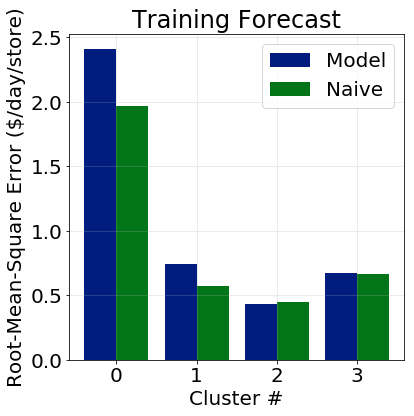

In [130]:
plot_rmse(cluster_rmse, naive_rmse, X_train_ss, yaxis_units='$/day/store', title='Training Forecast')

## Test Model

Cluster 0 decrease: -42.0
Cluster 1 decrease: -5.7
Cluster 2 decrease: 46.800000000000004
Cluster 3 decrease: 45.800000000000004

Average RMSE decrease ($/day/store):  0.08982698143315954

Average overall decrease: 24.8%


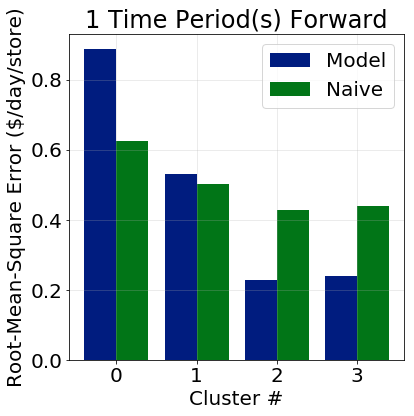

Cluster 0 decrease: 19.5
Cluster 1 decrease: 24.0
Cluster 2 decrease: 41.6
Cluster 3 decrease: 45.300000000000004

Average RMSE decrease ($/day/store):  0.22960738703543787

Average overall decrease: 37.6%


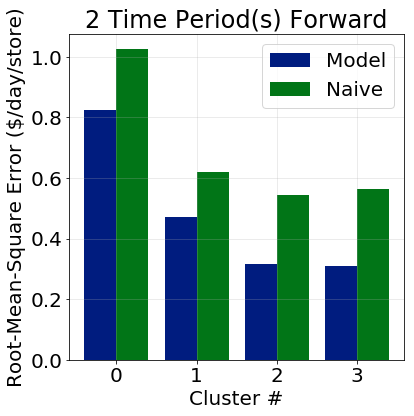

Cluster 0 decrease: 22.6
Cluster 1 decrease: 31.0
Cluster 2 decrease: 36.4
Cluster 3 decrease: 46.400000000000006

Average RMSE decrease ($/day/store):  0.2326679191179729

Average overall decrease: 37.1%


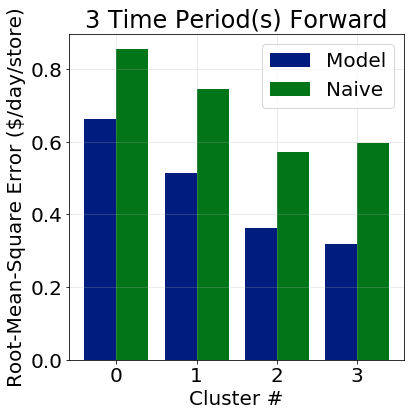

Cluster 0 decrease: 25.8
Cluster 1 decrease: 66.5
Cluster 2 decrease: 43.9
Cluster 3 decrease: 46.800000000000004

Average RMSE decrease ($/day/store):  0.28586945883409776

Average overall decrease: 41.8%


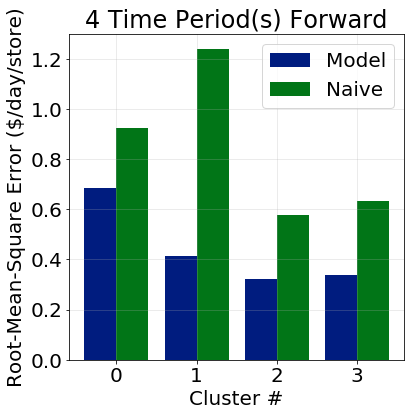

Cluster 0 decrease: 22.8
Cluster 2 decrease: 46.9
Cluster 3 decrease: 39.6

Average RMSE decrease ($/day/store):  0.18552337952743525

Average overall decrease: 38.3%


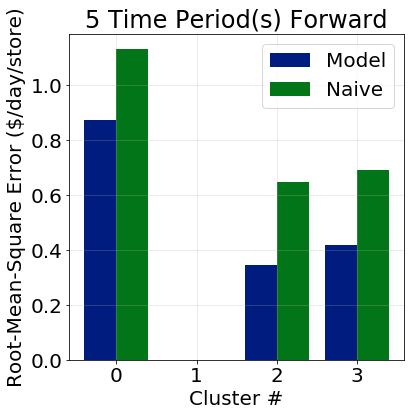

Cluster 0 decrease: 39.0
Cluster 2 decrease: 48.699999999999996
Cluster 3 decrease: 42.3

Average RMSE decrease ($/day/store):  0.23163454443677356

Average overall decrease: 43.8%


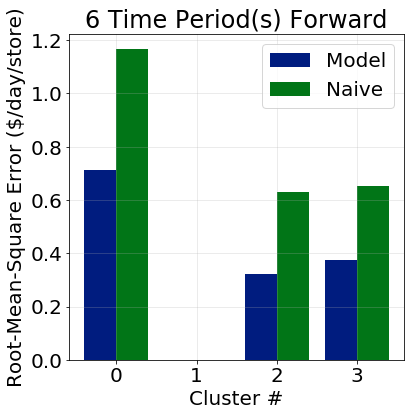

Cluster 0 decrease: 20.3
Cluster 2 decrease: 37.7
Cluster 3 decrease: 43.4

Average RMSE decrease ($/day/store):  0.13618855509300998

Average overall decrease: 36.1%


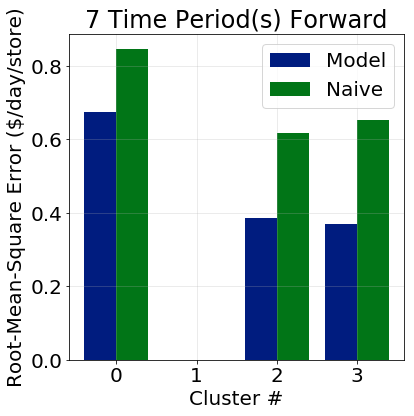

Cluster 0 decrease: 29.599999999999998
Cluster 2 decrease: 41.199999999999996
Cluster 3 decrease: 68.0

Average RMSE decrease ($/day/store):  0.15620498030481567

Average overall decrease: 49.6%


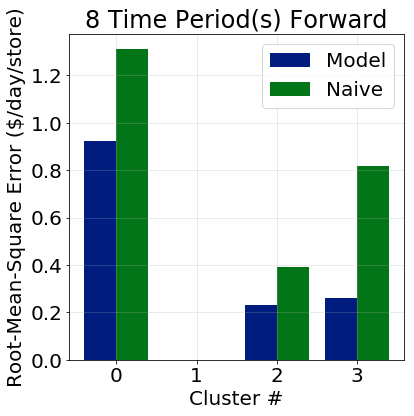

Cluster 0 decrease: 38.3
Cluster 2 decrease: 60.5
Cluster 3 decrease: 93.30000000000001

Average RMSE decrease ($/day/store):  0.43032813958484883

Average overall decrease: 69.0%


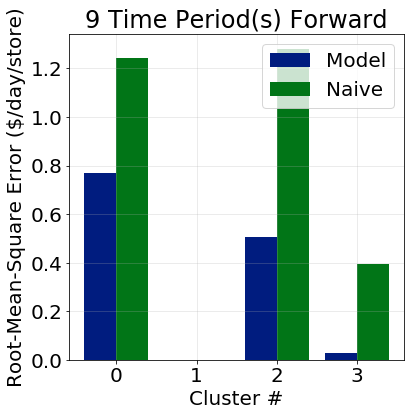

Cluster 0 decrease: 50.4
Cluster 2 decrease: 28.4

Average RMSE decrease ($/day/store):  0.2399532954915932

Average overall decrease: 37.0%


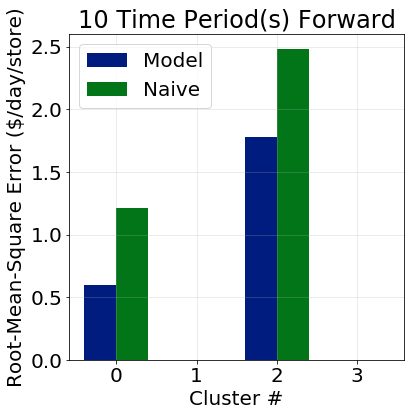

In [131]:
forc_model_test(X_test_ss, y_test, mlp_list, model_mask_cols)

In [97]:
(X_test_ss.groupby('cluster').count() / len(X_test_ss)).FD_ratio.values

array([0.22325767, 0.03277579, 0.34396655, 0.4       ])

## Forcast

In [53]:
def fit_forc_model(X, y, model_list, col_mask):
    forc_cluster_models = []
    for index, model in enumerate(model_list):
        clust_mask = X.cluster == str(index)
        model.fit(X[col_mask][clust_mask], y[clust_mask])
        forc_cluster_models.append(model)
    return forc_cluster_models

In [54]:
forc_cluster_models = fit_forc_model(X, y, mlp_list, model_mask_cols)

In [133]:
def update_cust_table(cust_table, add, i, pred):
    cust_table.set_value(add, 'period{}_forc_shrink_value_per_day_per_item'.format(i), pred)
    days_i = cust_table.columns.get_loc('days_between_visits')
    days = cust_table.loc[add][days_i]
    last_visit_i = cust_table.columns.get_loc('last_visit')
    last_visit = cust_table.loc[add][last_visit_i]
    next_visit = last_visit.to_datetime()  + pd.to_timedelta(i * days, unit='D')
    cust_table.set_value(add, 'period{}_pred_date'.format(i), next_visit)

In [134]:
def forc_model(X, y, forc_cluster_models, col_mask, cust_table, num_periods):
    lag1_loc = X[col_mask].columns.get_loc('shrink_value_per_day_lag1_by_store')
    lag2_loc = X[col_mask].columns.get_loc('shrink_value_per_day_lag2_by_store')
    for add in X.address1.unique():
        add_mask = X.address1 == add
        foo = X[ add_mask ].sort_values('visit_date', ascending=False)
        top_index = foo.index[0]
        clust = int(foo.cluster.values[0])
        # get values from last visit for store
        base_input = foo[col_mask].values[0]
        base_actual = y[top_index]
        lag2_val = base_input[lag1_loc]
        lag1_val = base_actual

        for i in range(1, num_periods + 1):
            model = forc_cluster_models[clust]
            inputs = base_input
            inputs[lag1_loc] = lag1_val
            inputs[lag2_loc] = lag2_val
            
            pred = model.predict(inputs.reshape(1, -1))
            update_cust_table(cust_table, add, i, pred)
                
            lag2_val = lag1_val
            lag1_val = pred

In [135]:
forc_model(X, y, forc_cluster_models, model_mask_cols, cust_table_agg, num_periods=4)

/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [138]:
cust_table_agg.head()

,qty_shrink_per_day,shrink_value_per_day,POP2010,FD_ratio,unemp_rate,dens_sq_mile,city,state,zip_code,customer_id,avg_UPC_per_visit,days_between_visits,last_visit,cluster,period1_forc_shrink_value_per_day_per_item,period2_forc_shrink_value_per_day_per_item,period3_forc_shrink_value_per_day_per_item,period4_forc_shrink_value_per_day_per_item,period1_pred_date,period2_pred_date,period3_pred_date,period4_pred_date
address1,,,,,,,,,,,,,,,,,,,,,,
#500 PACWEST/JACKSON,0.038061,0.347094,425363.0,0.228642,0.07,473.294897,BATTLE GROUND,WA,98604,3088198,2.250000,19.250000,2017-11-21,3,0.428779,0.650210,0.800977,0.855098,2017-12-10 06:00:00.000000,2017-12-29 12:00:00.000000,2018-01-17 18:00:00.000000,2018-02-06 00:00:00.000000
#501 PACWEST/JACKSON,0.041153,0.425020,425363.0,0.228642,0.08,2995.890411,VANCOUVER,WA,98665,3088198,3.250000,22.000000,2017-12-13,3,0.597576,0.658172,0.665824,0.654464,2018-01-04 00:00:00.000000,2018-01-26 00:00:00.000000,2018-02-17 00:00:00.000000,2018-03-11 00:00:00.000000
#502 PACWEST/JACKSON,0.035387,0.358387,425363.0,0.228642,0.08,2995.890411,VANCOUVER,WA,98665,3088198,2.777778,19.555556,2017-12-13,3,0.803009,0.841636,0.818517,0.790665,2018-01-01 13:20:00.038400,2018-01-21 02:39:59.990400,2018-02-09 16:00:00.028800,2018-03-01 05:19:59.980800
#504 PACWEST/JACKSON,-0.047619,-0.404762,735334.0,0.096296,0.07,4304.958678,PORTLAND,OR,97211,3088198,1.000000,0.000000,2017-10-30,2,NaN,NaN,NaN,NaN,2018-01-23 08:24:00.000000,2018-02-06 16:48:00.000000,2018-02-21 01:12:00.000000,2018-03-07 09:36:00.000000
#505 PACWEST/JACKSON,0.030754,0.133134,735334.0,0.096296,0.06,6111.880661,PORTLAND,OR,97232,3088198,2.000000,25.500000,2017-11-22,2,0.530822,0.617158,0.635988,0.635475,2017-12-17 12:00:00.000000,2018-01-12 00:00:00.000000,2018-02-06 12:00:00.000000,2018-03-04 00:00:00.000000


In [170]:
def pred_shrink_value(cust_table, start_date, end_date, num_periods):
    out_table = cust_table.copy()
    
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    day_diff = (end_date - start_date).days
    
    shrink_locs = []
    pred_date_locs = []
    for i in range(1, num_periods + 1):
        loc_shrink = cust_table.columns.get_loc('period{}_forc_shrink_value_per_day_per_item'.format(i))
        shrink_locs.append(loc_shrink)
        loc_pred_date = cust_table.columns.get_loc('period{}_pred_date'.format(i))
        pred_date_locs.append(loc_pred_date)
    for index, row in cust_table.iterrows():
        shrink_vals = []
        for place, date_loc in enumerate(pred_date_locs):
            if (row[date_loc] >= start_date) & (row[date_loc] <= end_date):
                shrink_loc = shrink_locs[place]
                shrink_vals.append(row[shrink_loc])
        agg_value = np.mean(shrink_vals) * day_diff
        out_table.set_value(index, 'agg_shrink_value', agg_value)
    return out_table

In [165]:
agg_table = pred_shrink_value(cust_table_agg, start_date='02/01/2018', end_date='03/01/2018', num_periods=4)

/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [177]:
agg_table.sort_values('agg_shrink_value')

,qty_shrink_per_day,shrink_value_per_day,POP2010,FD_ratio,unemp_rate,dens_sq_mile,city,state,zip_code,customer_id,avg_UPC_per_visit,days_between_visits,last_visit,cluster,period1_forc_shrink_value_per_day_per_item,period2_forc_shrink_value_per_day_per_item,period3_forc_shrink_value_per_day_per_item,period4_forc_shrink_value_per_day_per_item,period1_pred_date,period2_pred_date,period3_pred_date,period4_pred_date,agg_shrink_value
address1,,,,,,,,,,,,,,,,,,,,,,,
7 ELEVEN SBT PROGRAM #20722,0.020305,-0.197206,3095313.0,0.146954,0.07,3952.688495,SAN DIEGO,CA,92120,2773156,1.750000,56.250000,2017-12-21,2,-0.862758,0.099403,0.504469,0.614433,2018-02-15 06:00:00.000000,2018-04-12 12:00:00.000000,2018-06-07 18:00:00.000000,2018-08-03 00:00:00.000000,-24.157236
7 ELEVEN SBT PROGRAM #34130,-0.008967,-0.069254,1809034.0,0.314834,0.05,305.125543,BENBROOK,TX,76126,2773156,2.000000,32.571429,2018-01-02,3,-0.772338,0.041885,0.556416,0.741771,2018-02-03 13:42:51.465600,2018-03-08 03:25:42.844800,2018-04-09 17:08:34.310400,2018-05-12 06:51:25.689600,-21.625456
7 ELEVEN SBT PROGRAM #21888,-0.005082,0.057376,1029655.0,0.129198,0.06,5528.067561,SALT LAKE CITY,UT,84106,2773156,3.571429,34.000000,2018-01-02,2,-0.624409,-0.087508,0.138603,0.200010,2018-02-05 00:00:00.000000,2018-03-11 00:00:00.000000,2018-04-14 00:00:00.000000,2018-05-18 00:00:00.000000,-17.483446
SPEEDWAY #7853,-0.056777,-0.746031,1339532.0,0.057037,0.04,1932.639692,SYOSSET,NY,11791,2331150,1.666667,67.000000,2017-11-29,2,-0.544865,0.455560,0.860039,0.964481,2018-02-04 00:00:00.000000,2018-04-12 00:00:00.000000,2018-06-18 00:00:00.000000,2018-08-24 00:00:00.000000,-15.256222
RICH OIL #7785,-0.093710,-1.237058,250331.0,0.323153,0.11,2471.145038,KALAMAZOO,MI,49008,2331150,1.250000,24.500000,2018-01-09,3,-2.120220,1.220999,1.570406,1.203341,2018-02-02 12:00:00.000000,2018-02-27 00:00:00.000000,2018-03-23 12:00:00.000000,2018-04-17 00:00:00.000000,-12.589092
KWIK CHEK #37,0.090476,0.591952,86129.0,0.084764,0.06,27.100907,WOLFE CITY,TX,75496,3083182,1.250000,58.000000,2017-12-19,2,-0.430960,-0.029746,0.227720,0.326055,2018-02-15 00:00:00.000000,2018-04-14 00:00:00.000000,2018-06-11 00:00:00.000000,2018-08-08 00:00:00.000000,-12.066893
7 ELEVEN SBT PROGRAM #24440,-0.008445,-0.142463,9818605.0,0.069501,0.09,12649.706980,GARDENA,CA,90247,2773156,3.166667,34.500000,2018-01-08,1,-0.424569,0.084357,0.337231,0.462852,2018-02-11 12:00:00.000000,2018-03-18 00:00:00.000000,2018-04-21 12:00:00.000000,2018-05-26 00:00:00.000000,-11.887945
7 ELEVEN SBT PROGRAM #33847,-0.033333,-0.166667,703462.0,0.354518,0.05,1194.844297,LAKE ZURICH,IL,60047,2773156,1.666667,63.666667,2017-12-15,3,-0.382250,0.161087,0.499474,0.624779,2018-02-16 16:00:00.028800,2018-04-21 07:59:59.971200,2018-06-24 00:00:00.000000,2018-08-26 16:00:00.028800,-10.703013
7 ELEVEN SBT PROGRAM #37297,0.002806,0.048633,277789.0,0.447562,0.11,1645.534256,PORT SAINT LUCIE,FL,34952,2773156,2.000000,52.250000,2017-12-11,3,-0.331331,0.177215,0.506593,0.635080,2018-02-01 06:00:00.000000,2018-03-25 12:00:00.000000,2018-05-16 18:00:00.000000,2018-07-08 00:00:00.000000,-9.277266


In [208]:
def flag(cust_table, mult_over_min=4, amount_over_min=100, and_or='and'):
    foo = cust_table[ cust_table.agg_shrink_value > 0 ] \
        .groupby(['zip_code', 'address1']).sum()[['agg_shrink_value']].reset_index()
    loc_agg = foo.columns.get_loc('agg_shrink_value')
    loc_add = foo.columns.get_loc('address1')
    for zip in foo.zip_code.unique():
        bar = foo[ foo.zip_code == zip]
        min_val = bar.agg_shrink_value.min()
        for _, row in bar.iterrows():
            shrink_val = row[loc_agg]
            val_times_over_min = shrink_val / min_val
            val_amount_over_min = shrink_val - min_val
            if and_or == 'or':
                if (val_times_over_min >= 4) | (val_amount_over_min >= amount_over_min):
                    print(row[loc_add], ' - ', val_times_over_min, ' - ', val_amount_over_min)
            else:
                if (val_times_over_min >= 4) & (val_amount_over_min >= amount_over_min):
                    print(row[loc_add], ' - ', val_times_over_min, ' - ', val_amount_over_min)

In [209]:
flag(agg_table)

SPEEDWAY #9222  -  18.971139489682994  -  301.78098176290996
SPEEDWAY #9259  -  20.879168678965545  -  176.8891174768396
SHEETZ - DSD #254  -  4.968134505932008  -  100.72889527247054
SHEETZ - DSD #506  -  14.951684222837995  -  160.8866169066976
SPEEDWAY #9699  -  5.740165296558122  -  104.22382458236171
SPEEDWAY #9704  -  9.722493514292642  -  174.98352018581718
SPEEDWAY #1231  -  7.645648759711311  -  103.78173212951
SPEEDWAY #1401  -  6.900884291803062  -  117.83676746194635
SPEEDWAY #9314  -  12.119105189120075  -  197.0779657844124
SPEEDWAY #5401  -  7.286146284467112  -  133.7938983130113
SPEEDWAY #2201  -  26.641186337999162  -  123.32673722225343
SPEEDWAY #2371  -  11.967485081479891  -  206.45061792170648
SPEEDWAY #4100  -  7.94594330935911  -  126.86573986732024
SPEEDWAY #7382  -  26.05898249389875  -  118.05450975613438


## Test other NNs

In [ ]:
def keras_MLP(X_train, X_test, y_train):
    model = Sequential()
    model.add(Dense(16, input_dim=X_train.shape[1]))
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
#     model.add(Dense(64, init='uniform'))
#     model.add(Activation('tanh'))
    adam = Adam()
    model.compile(loss='mean_squared_error', optimizer=adam)
    model.fit(X_train, y_train, nb_epoch=20, batch_size=16)

In [ ]:
keras_MLP(X_train[model_mask_cols], X_test, y_train)

In [ ]:
X_train[model_mask_cols].shape

In [ ]:
reg = Regressor()